In [21]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [22]:
df_train = pd.read_csv("./data/train.csv",dtype={'일시':int})

In [23]:
df_train.head()

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308


<AxesSubplot:>

c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\

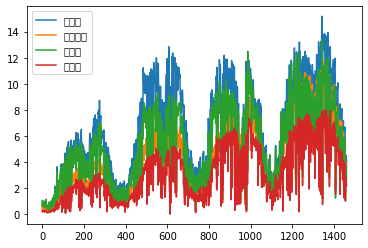

In [24]:
df_train.iloc[:,1:].plot()

<AxesSubplot:>

c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44305 (\N{HANGUL SYLLABLE GWANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\s_dojh99\Miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\

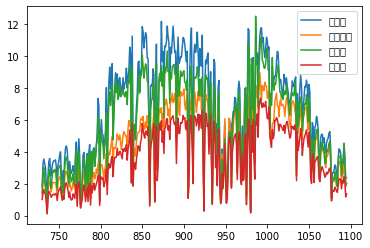

In [25]:
df_train[(df_train['일시'] >= 20200101) & (df_train['일시'] < 20210001)].iloc[:,1:].plot()

In [26]:
def dfByDateRange(dt_start:datetime,dt_end:datetime):
    dts=[]
    dt_cur = dt_start
    while dt_cur <= dt_end:
        dts.append(dt_cur.year*10000 + dt_cur.month*100 + dt_cur.day)
        dt_cur += timedelta(days=1)

    return pd.DataFrame({'일시': dts})

In [27]:
def preprocess(df,holiday_path,makeY=False):
    df_holiday =  pd.read_csv(holiday_path,dtype={'locdate':int})

    holidays = df_holiday['locdate'].apply(lambda x : datetime(year=int(x//1e4), month = int((x%1e4)//100), day=int(x%100)))
    
    df_features = pd.DataFrame()
    df_features['date'] = df['일시'].apply(lambda x : datetime(year=int(x//1e4), month = int((x%1e4)//100), day=int(x%100)))
    df_features['weekday'] = df_features['date'].apply(lambda date : date.weekday()) / 7.0
    df_features['month'] = df_features['date'].apply(lambda date : date.month) / 12.0
    #df_features['day_of_month']= df_features['date'].apply(lambda date : date.day) 
    df_features['day_of_year'] = df_features['date'].apply(lambda date : date.timetuple().tm_yday) / 365.0 
    df_features['red'] = df_features['date'].isin(holidays) | df_features['weekday'].isin([5,6]) #saturday sunday
    df_features['year'] = df_features['date'].apply(lambda date : date.year) / 2018.0
    df_features['week_of_year']=df_features['date'].apply(lambda date : date.isocalendar()[1]) / 53.0

    df_features['vacation'] = False
    df_features['rainy_season'] = df_features['date'].apply(lambda date : 726 >= date.month*100 + date.day >= 625)

    for i in range(1,df_features.shape[0]-1):
        if df_features["red"][i] & df_features["red"][i-1] & df_features["red"][i+1]:
            df_features.at[i-1,"vacation"] = True
            df_features.at[i,"vacation"] = True
            df_features.at[i+1,"vacation"] = True


    cols_location = ['광진구','동대문구','성동구','중랑구']
    list_df_features_by_loc = []
    for idx, loc in enumerate(cols_location):
        df_new = df_features.copy()
        df_new['loc'] = idx
        if makeY:
            df_new['y']=df[loc]
        list_df_features_by_loc.append(df_new)

    df_ret=pd.concat(list_df_features_by_loc)
    df_ret = df_ret.reset_index(drop=True)

    df_ret = df_ret.drop('date',axis=1)

    return df_ret


In [28]:
df_processed = preprocess(df_train,'./data/holiday_train.csv',makeY=True)

df_trainX = df_processed.drop(['y'],axis=1)
df_trainY = df_processed['y']

In [29]:
df_trainX.tail()

,weekday,month,day_of_year,red,year,week_of_year,vacation,rainy_season,loc
5839,0.000000,1.0,0.989041,False,1.001487,0.981132,False,False,3
5840,0.142857,1.0,0.991781,False,1.001487,0.981132,False,False,3
5841,0.285714,1.0,0.994521,False,1.001487,0.981132,False,False,3
5842,0.428571,1.0,0.997260,False,1.001487,0.981132,False,False,3
5843,0.571429,1.0,1.000000,False,1.001487,0.981132,False,False,3


In [30]:
from pygam import GAM,s,f
import matplotlib.pyplot as plt

# gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+f(4)+s(5)+s(6)+f(7)).fit(df_trainX,df_trainY)
#gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+f(4)+s(5)+s(6)+f(7)+f(8)+f(9))
gam = GAM(s(0)+s(1)+s(2,n_splines=100)+f(3)+s(4)+s(5,n_splines=50)+f(6),distribution='poisson',link='log')
gam.gridsearch(df_trainX.values,df_trainY.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:08
c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1112: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden'] = full_ll/null_ll
c:\Users\s_dojh99\Miniconda3\lib\site-packages\pygam\pygam.py:1113: RuntimeWarning: invalid value encountered in double_scalars
  r2['McFadden_adj'] = 1. - (full_ll - self.statistics_['edof'])/null_ll
 18% (2 of 11) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:05
c:\Users\s_dojh99\Miniconda3\lib

GAM(callbacks=[Deviance(), Diffs()], distribution=PoissonDist(), 
   fit_intercept=True, link=LogLink(), max_iter=100, 
   terms=s(0) + s(1) + s(2) + f(3) + s(4) + s(5) + f(6) + intercept, 
   tol=0.0001, verbose=False)

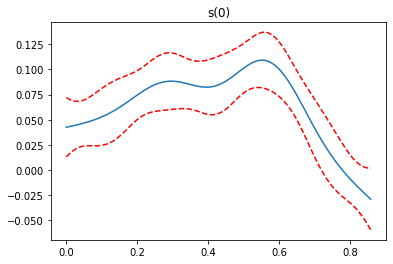

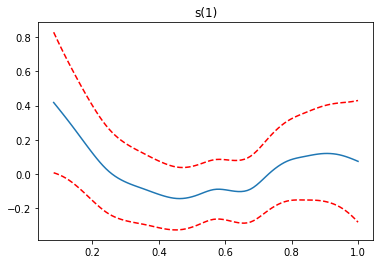

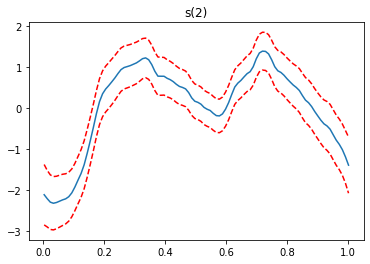

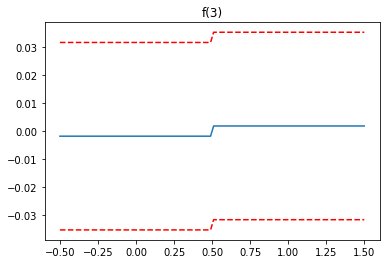

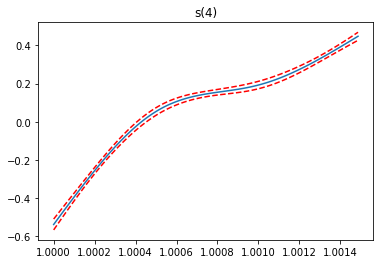

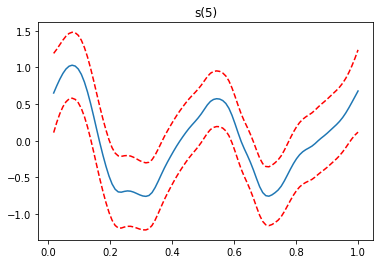

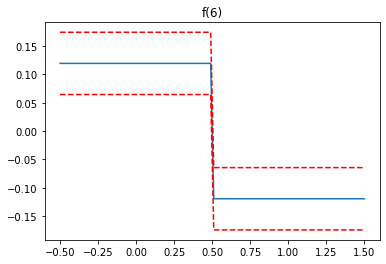

In [31]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

In [32]:
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     76.5968
Link Function:                          LogLink Log Likelihood:                                       -inf
Number of Samples:                         5844 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                               2.8055
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6308
Feature Function                  Lam

C:\Users\s_dojh99\AppData\Local\Temp/ipykernel_16752/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [33]:
df_test = dfByDateRange(datetime(year=2022,month=1,day=1),datetime(year=2022,month=11,day=30))

In [34]:
df_testX = preprocess(df_test,'./data/holiday_test.csv')

In [35]:
prediction = gam.predict(df_testX)
prediction[prediction<0.01] = 0.01

In [36]:
n_dates = len(prediction)//4
df_submission = pd.DataFrame({
    '일시':df_test['일시'].values,
    '광진구':prediction[:n_dates],
    '동대문구':prediction[n_dates:2*n_dates],
    '성동구':prediction[2*n_dates:3*n_dates],
    '중랑구':prediction[3*n_dates:]
})

In [37]:
df_submission.tail()

,일시,광진구,동대문구,성동구,중랑구
329,20221126,7.174098,7.174098,7.174098,7.174098
330,20221127,6.558747,6.558747,6.558747,6.558747
331,20221128,7.330390,7.330390,7.330390,7.330390
332,20221129,7.257007,7.257007,7.257007,7.257007
333,20221130,7.257791,7.257791,7.257791,7.257791


In [38]:
filename = f"sub_gam_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
print(filename)
df_submission.to_csv(f"./out/{filename}", index=False)

sub_gam_20221204_132535.csv


In [39]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

trainX = df_processed[df_processed['year']<2021/2018.0].drop(['y'],axis=1)
trainy = df_processed[df_processed['year']<2021/2018.0]['y']
valX = df_processed[df_processed['year']>=2021/2018.0].drop(['y'],axis=1)
valY = df_processed[df_processed['year']>=2021/2018.0]['y']

In [41]:
from pygam import LinearGAM

# gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+f(4)+s(5)+s(6)+f(7)).fit(df_trainX,df_trainY)
#gam = LinearGAM(s(0)+s(1)+s(2)+s(3)+f(4)+s(5)+s(6)+f(7)+f(8)+f(9))
gam = LinearGAM(s(0)+s(1)+s(2)+f(3)+s(4)+s(5)+f(6))
gam.gridsearch(trainX.values,trainy.values)

gam_val_yhat=gam.predict(valX.values)
mae = np.mean(np.abs(gam_val_yhat-valY.values))
print(mae)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:01 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:01 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


2.187094708862493


In [42]:
randomForest = RandomForestRegressor(criterion='mse',n_estimators=1000)

randomForest.fit(trainX,trainy)
rf_val_yhat=randomForest.predict(valX)
mae = np.mean(np.abs(rf_val_yhat-valY.values))
print(mae)

2.310932376712328


In [43]:
extratrees = ExtraTreesRegressor(criterion='mse',n_estimators=1000)

extratrees.fit(trainX,trainy)
ets_val_yhat=extratrees.predict(valX)
mae = np.mean(np.abs(ets_val_yhat-valY.values))
print(mae)

2.3167805657534233


In [44]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(trainX,trainy)
dt_val_yhat=dt.predict(valX)
mae = np.mean(np.abs(dt_val_yhat-valY.values))
print(mae)

2.4523287671232876


In [45]:
from sklearn.tree import ExtraTreeRegressor

et = ExtraTreeRegressor()

et.fit(trainX,trainy)
et_val_yhat=et.predict(valX)
mae = np.mean(np.abs(et_val_yhat-valY.values))
print(mae)

2.407709589041096


In [46]:
from catboost import CatBoostRegressor

DEV="cpu"

params = {
    'learning_rate': 0.01, 
    #'max_depth':8,
    'objective': 'MAE',
    'early_stopping_rounds' : 10000,
    'eval_metric':'MAE',
    'iterations':50000,
    'random_seed':42,
    'metric_period':1000,
    #'boosting':'dart',
}

if DEV.upper() == "GPU" : 
    params['task_type'] = "GPU"
    params['boosting_type'] = 'Plain'

models = []


reg = CatBoostRegressor(**params)
reg.fit(X=trainX, y = trainy, eval_set = [(valX,valY)])

cat_val_yhat = reg.predict(valX)
print("==================================")

mae = np.mean(np.abs(cat_val_yhat-valY.values))
print(mae)

0:	learn: 2.2044384	test: 3.6662832	best: 3.6662832 (0)	total: 149ms	remaining: 2h 4m 16s
1000:	learn: 0.7206893	test: 2.0402842	best: 2.0247754 (541)	total: 1.77s	remaining: 1m 26s
2000:	learn: 0.6457180	test: 2.0876575	best: 2.0247754 (541)	total: 3.37s	remaining: 1m 20s
3000:	learn: 0.5924889	test: 2.1192880	best: 2.0247754 (541)	total: 4.99s	remaining: 1m 18s
4000:	learn: 0.5486011	test: 2.1426136	best: 2.0247754 (541)	total: 6.67s	remaining: 1m 16s
5000:	learn: 0.5188285	test: 2.1578837	best: 2.0247754 (541)	total: 8.32s	remaining: 1m 14s
6000:	learn: 0.4928770	test: 2.1698918	best: 2.0247754 (541)	total: 9.95s	remaining: 1m 12s
7000:	learn: 0.4766741	test: 2.1764941	best: 2.0247754 (541)	total: 11.6s	remaining: 1m 11s
8000:	learn: 0.4582247	test: 2.1828710	best: 2.0247754 (541)	total: 13.3s	remaining: 1m 9s
9000:	learn: 0.4432140	test: 2.1892557	best: 2.0247754 (541)	total: 15s	remaining: 1m 8s
10000:	learn: 0.4299699	test: 2.1937488	best: 2.0247754 (541)	total: 16.7s	remaining: 

In [47]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor()

knr.fit(trainX,trainy)
knr_val_yhat=knr.predict(valX)
mae = np.mean(np.abs(knr_val_yhat-valY.values))
print(mae)

2.9037372602739726


In [48]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet()

elastic.fit(trainX,trainy)
elastic_val_yhat=elastic.predict(valX)
mae = np.mean(np.abs(elastic_val_yhat-valY.values))
print(mae)

3.3505534271572848


In [49]:
from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(trainX,trainy)
lasso_val_yhat=lasso.predict(valX)
mae = np.mean(np.abs(lasso_val_yhat-valY.values))
print(mae)

3.377452077292271


In [50]:
from sklearn.svm import SVR

svr = SVR()

svr.fit(trainX,trainy)
svr_val_yhat=svr.predict(valX)
mae = np.mean(np.abs(svr_val_yhat-valY.values))
print(mae)

3.1427241049994885


In [51]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor()

ada.fit(trainX,trainy)
ada_val_yhat=ada.predict(valX)
mae = np.mean(np.abs(ada_val_yhat-valY.values))
print(mae)

2.4856166111011446


In [52]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor()

bagging.fit(trainX,trainy)
bagging_val_yhat=bagging.predict(valX)
mae = np.mean(np.abs(bagging_val_yhat-valY.values))
print(mae)

2.3089893150684935


In [53]:
from sklearn.ensemble import GradientBoostingRegressor

gd = GradientBoostingRegressor()

gd.fit(trainX,trainy)
gd_val_yhat=gd.predict(valX)
mae = np.mean(np.abs(gd_val_yhat-valY.values))
print(mae)

2.208844025143


In [54]:
mae = np.mean(np.abs((gam_val_yhat*0.35+cat_val_yhat*0.35+rf_val_yhat*0.1+ets_val_yhat*0.1+knr_val_yhat*0.1)-valY.values))
print(mae)

2.143548980896346
